In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, Reshape
#from tensorflow.keras.layers import RepeatVector
#from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.models import model_from_json
from datetime import date, timedelta
from matplotlib import pyplot as plt
import math
from get_data import get_stock_data

import tensorflow as tf

import pandas as pd
import numpy as np
from datetime import date
import nsepy as nse
import talib

In [66]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
from numpy.random import seed
seed(1)
from tensorflow.compat.v1 import set_random_seed
set_random_seed(2)

In [67]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("tf.__version__ is", tf.__version__)
print("tf.keras.__version__ is:", tf.keras.__version__)



def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

#_get_available_gpus()

Num GPUs Available:  1
tf.__version__ is 2.2.0
tf.keras.__version__ is: 2.3.0-tf


# FETCHING THE DATA

In [6]:
def get_stock_data(ticker, start_date, end_date):

    print(end_date, type(ticker))
    data = nse.get_history(symbol=ticker, start=start_date,
                           end= end_date)
    #data = nse.get_history(symbol= ticker, start=start_date, end= end_date)

    data = data.drop(['Prev Close','Symbol', 'Series', 'Deliverable Volume', '%Deliverble', 'Trades', 'Last'], axis = 1)

    close = data['Close'].values
    high = data['High'].values
    low = data['Low'].values

    #Computing technical indicators
    data['upB'], data['midB'], data['lowB'] = talib.BBANDS(close, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    data['RSI'] = talib.RSI(close, timeperiod=10)
    data['K'], d = talib.STOCH(high, low, close, fastk_period=14, slowk_period=14, slowk_matype=0, slowd_period=3,
                               slowd_matype=0)
    macd, macdsignal, data['MACD'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)

    data['EMA'] = talib.EMA(close, timeperiod=30)
    data['ADX'] = talib.ADX(high, low, close, timeperiod=14)
    data['AroonUp'], data['AroonDown'] = talib.AROON(high, low, timeperiod=14)
    data['diff'] = data['High'] - data['Low']
    data = data.dropna()


    #saving as a csv file
    data.to_csv('stock_prices' + str(ticker) + '.csv', index=False)

# TRAINING...

In [4]:
ticker = input("Please enter symbol: ")
present_date = date.today()
prev_date = date.today() - timedelta(days = 5457)
print(date(present_date.year, present_date.month, present_date.day))
get_stock_data(ticker,start_date = prev_date, end_date = present_date)

Please enter symbol: SBIN
2021-01-29
2021-01-29 <class 'str'>


In [5]:
dataset = pd.read_csv('stock_prices' + ticker + '.csv')

#print(dataset['Close'])
close = dataset['Close'].values

#new_dataset = dataset.drop(['Close'], axis = 1)
print(dataset)
print(close)
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled = scaler.fit_transform(dataset.values)

        Open    High     Low   Close    VWAP    Volume      Turnover  \
0     989.90  989.90  952.10  964.30  964.47   2403864  2.318456e+14   
1     968.00  968.00  932.05  937.85  949.75   1684270  1.599635e+14   
2     937.00  937.00  897.00  918.35  919.63   2311978  2.126166e+14   
3     920.00  935.55  905.00  931.65  922.35   1916844  1.767997e+14   
4     935.55  980.20  935.55  943.20  947.26   2183961  2.068780e+14   
...      ...     ...     ...     ...     ...       ...           ...   
3671  295.50  298.00  282.40  283.70  289.30  44440810  1.285668e+15   
3672  284.50  288.00  277.05  280.95  283.38  34034630  9.644829e+14   
3673  280.20  284.85  272.70  275.65  278.67  39211107  1.092677e+15   
3674  271.90  283.35  269.50  282.35  277.04  48717297  1.349668e+15   
3675  285.60  290.65  279.10  282.10  283.48  42300984  1.199128e+15   

              upB      midB        lowB        RSI          K       MACD  \
0     1010.289491  969.5200  928.750509  49.962465  75.7544

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(dataset.values)

In [68]:
train_gen = TimeseriesGenerator(scaled, close, start_index = 0, end_index = int(len(scaled) * 0.8), length = 3, batch_size = 256)
test_gen = TimeseriesGenerator(scaled, close, start_index = int(len(scaled) * 0.8), end_index = int(len(scaled) - 1), length = 3, batch_size = 256)

In [69]:
for i in test_gen:
    print(i)

(array([[[0.04203635, 0.0446487 , 0.04368623, ..., 0.85714286,
         0.35714286, 0.02018737],
        [0.04325912, 0.04384556, 0.04442796, ..., 0.78571429,
         0.28571429, 0.00869953],
        [0.04064956, 0.04140639, 0.04144591, ..., 0.71428571,
         0.21428571, 0.0123801 ]],

       [[0.04325912, 0.04384556, 0.04442796, ..., 0.78571429,
         0.28571429, 0.00869953],
        [0.04064956, 0.04140639, 0.04144591, ..., 0.71428571,
         0.21428571, 0.0123801 ],
        [0.04078376, 0.04030579, 0.03837304, ..., 1.        ,
         0.14285714, 0.02676779]],

       [[0.04064956, 0.04140639, 0.04144591, ..., 0.71428571,
         0.21428571, 0.0123801 ],
        [0.04078376, 0.04030579, 0.03837304, ..., 1.        ,
         0.14285714, 0.02676779],
        [0.03663828, 0.03840205, 0.03814598, ..., 1.        ,
         0.07142857, 0.01416462]],

       ...,

       [[0.03353663, 0.03340472, 0.03346856, ..., 1.        ,
         0.21428571, 0.01115325],
        [0.03249281,

In [80]:
model = Sequential()
model.add(Reshape((3,1,1,18), input_shape = (3,18)))
model.add(ConvLSTM2D(64, kernel_size = 3, padding = 'same', return_sequences = True, recurrent_dropout = 0.4, data_format='channels_first'))
#model.add(ConvLSTM2D(18, kernel_size = 3, padding = 'same', return_sequences = True, recurrent_dropout = 0.4, data_format='channels_first'))
model.add(Flatten())
model.add(Dense(1, activation = 'linear'))

In [81]:
adadelta = Adadelta(learning_rate=1.0, rho=0.95)
model.compile(loss= 'mse', optimizer = adadelta, metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 3, 1, 1, 18)       0         
_________________________________________________________________
conv_lst_m2d_4 (ConvLSTM2D)  (None, 3, 64, 1, 18)      150016    
_________________________________________________________________
flatten_4 (Flatten)          (None, 3456)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 3457      
Total params: 153,473
Trainable params: 153,473
Non-trainable params: 0
_________________________________________________________________


In [82]:
history = model.fit_generator(train_gen, epochs = 200, verbose = 2, shuffle = False, validation_data = test_gen)

Epoch 1/200
12/12 - 2s - loss: 2873795.5000 - mean_absolute_percentage_error: 99.0975 - val_loss: 66403.4453 - val_mean_absolute_percentage_error: 94.0458
Epoch 2/200
12/12 - 2s - loss: 2495098.5000 - mean_absolute_percentage_error: 71.9666 - val_loss: 2531.5911 - val_mean_absolute_percentage_error: 16.8260
Epoch 3/200
12/12 - 2s - loss: 1875609.3750 - mean_absolute_percentage_error: 84.4458 - val_loss: 56202.5664 - val_mean_absolute_percentage_error: 94.3236
Epoch 4/200
12/12 - 2s - loss: 1453381.7500 - mean_absolute_percentage_error: 96.7740 - val_loss: 184454.6562 - val_mean_absolute_percentage_error: 170.0640
Epoch 5/200
12/12 - 2s - loss: 1162778.8750 - mean_absolute_percentage_error: 106.7339 - val_loss: 346540.7500 - val_mean_absolute_percentage_error: 232.2381
Epoch 6/200
12/12 - 1s - loss: 964167.1250 - mean_absolute_percentage_error: 114.9369 - val_loss: 512833.7500 - val_mean_absolute_percentage_error: 281.8930
Epoch 7/200
12/12 - 2s - loss: 834180.8750 - mean_absolute_perce

Epoch 54/200
12/12 - 2s - loss: 53921.0820 - mean_absolute_percentage_error: 19.9472 - val_loss: 25007.4727 - val_mean_absolute_percentage_error: 50.3916
Epoch 55/200
12/12 - 2s - loss: 52734.0195 - mean_absolute_percentage_error: 19.5605 - val_loss: 24141.2852 - val_mean_absolute_percentage_error: 49.2754
Epoch 56/200
12/12 - 2s - loss: 51883.0547 - mean_absolute_percentage_error: 19.4206 - val_loss: 23451.5469 - val_mean_absolute_percentage_error: 48.3495
Epoch 57/200
12/12 - 1s - loss: 51691.3945 - mean_absolute_percentage_error: 19.1099 - val_loss: 23578.7773 - val_mean_absolute_percentage_error: 48.3978
Epoch 58/200
12/12 - 1s - loss: 50819.2773 - mean_absolute_percentage_error: 18.9847 - val_loss: 23067.5527 - val_mean_absolute_percentage_error: 47.7235
Epoch 59/200
12/12 - 2s - loss: 50154.2930 - mean_absolute_percentage_error: 18.6076 - val_loss: 22459.7402 - val_mean_absolute_percentage_error: 46.8975
Epoch 60/200
12/12 - 2s - loss: 49071.0742 - mean_absolute_percentage_error:

Epoch 108/200
12/12 - 2s - loss: 35629.5625 - mean_absolute_percentage_error: 15.1539 - val_loss: 16702.2520 - val_mean_absolute_percentage_error: 37.5492
Epoch 109/200
12/12 - 2s - loss: 34891.7422 - mean_absolute_percentage_error: 14.9869 - val_loss: 16620.2461 - val_mean_absolute_percentage_error: 37.4326
Epoch 110/200
12/12 - 2s - loss: 34423.8164 - mean_absolute_percentage_error: 14.7818 - val_loss: 16600.5234 - val_mean_absolute_percentage_error: 37.4086
Epoch 111/200
12/12 - 2s - loss: 34543.8086 - mean_absolute_percentage_error: 14.7873 - val_loss: 16582.4805 - val_mean_absolute_percentage_error: 37.3998
Epoch 112/200
12/12 - 2s - loss: 34004.9336 - mean_absolute_percentage_error: 14.6491 - val_loss: 16603.9609 - val_mean_absolute_percentage_error: 37.4202
Epoch 113/200
12/12 - 2s - loss: 34188.4609 - mean_absolute_percentage_error: 14.8261 - val_loss: 16591.7578 - val_mean_absolute_percentage_error: 37.3837
Epoch 114/200
12/12 - 2s - loss: 33625.4297 - mean_absolute_percentage

Epoch 161/200
12/12 - 2s - loss: 27874.3223 - mean_absolute_percentage_error: 13.3109 - val_loss: 14943.1211 - val_mean_absolute_percentage_error: 35.4288
Epoch 162/200
12/12 - 2s - loss: 27718.5195 - mean_absolute_percentage_error: 13.2299 - val_loss: 15023.4570 - val_mean_absolute_percentage_error: 35.4770
Epoch 163/200
12/12 - 2s - loss: 28078.5215 - mean_absolute_percentage_error: 13.3075 - val_loss: 14898.1523 - val_mean_absolute_percentage_error: 35.3175
Epoch 164/200
12/12 - 2s - loss: 28064.5234 - mean_absolute_percentage_error: 13.3681 - val_loss: 14903.1025 - val_mean_absolute_percentage_error: 35.3224
Epoch 165/200
12/12 - 2s - loss: 27683.1309 - mean_absolute_percentage_error: 13.2965 - val_loss: 14847.8135 - val_mean_absolute_percentage_error: 35.2635
Epoch 166/200
12/12 - 2s - loss: 27536.3594 - mean_absolute_percentage_error: 13.2310 - val_loss: 14888.9238 - val_mean_absolute_percentage_error: 35.3054
Epoch 167/200
12/12 - 2s - loss: 27113.7012 - mean_absolute_percentage

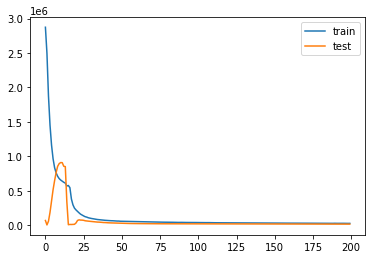

3/3 [==============================] - 0s 22ms/step - loss: 13966.6621 - mean_absolute_percentage_error: 33.9209

Test loss: 13966.662109375
Test accuracy: 33.92089080810547



In [83]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
score = model.evaluate_generator(test_gen, verbose = 1)
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print()

In [84]:
def plot_them_graphs(actual, predicted, type, ticker):
    '''pred = np.zeros((actual.shape[0], 18))
    pred[:, 3] = actual[:, 0]
    pred = np.around(scaler.inverse_transform(pred), decimals=2)

    pred1 = np.zeros((actual.shape[0], 18))
    pred1[:, 3] = predicted[:, 0]
    pred1 = np.around(scaler.inverse_transform(pred1), decimals=2)'''

    plt.figure()
    plt.plot(actual, label='actual')
    plt.plot(predicted, label='predicted')
    plt.legend()
    #fig1 = plt.gcf()
    plt.savefig(ticker + '_' + type + "conv.jpg", transparent=False)
    plt.show()

In [85]:
def reshape_actual(actual_data):

    
    shaped_data = [actual_data[i][1] for i in range(len(actual_data))]
    shaped_data = np.concatenate(shaped_data, axis=0)
    print(shaped_data)
    shaped_data = shaped_data.reshape((shaped_data.shape[0], 1))
    return shaped_data


[931.65 943.2  938.05 ... 291.75 292.8  301.4 ]


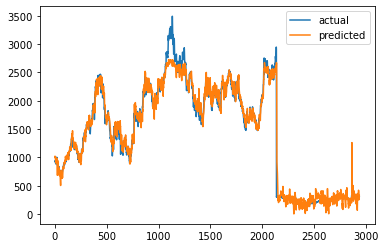

In [86]:
actual_train = reshape_actual(train_gen)
predictions_train = model.predict_generator(train_gen, verbose = 0)
plot_them_graphs(actual_train, predictions_train, "train", ticker)

In [87]:
actual_test = reshape_actual(test_gen)
print(actual_test.shape)
predictions_test = model.predict_generator(test_gen, verbose = 0)
rmse_test = math.sqrt(mean_squared_error(actual_test[:], predictions_test[:]))
print()
print(rmse_test)

[276.2  278.7  271.65 268.5  269.65 273.3  272.6  276.05 274.45 267.6
 268.   262.15 263.5  256.55 246.65 256.8  253.25 252.85 254.7  257.05
 253.7  252.3  247.95 249.1  248.   241.55 234.8  246.5  254.35 249.9
 246.15 250.5  247.3  259.3  259.7  260.65 263.3  257.05 253.8  250.95
 249.   248.15 246.45 246.15 241.2  242.45 240.6  237.2  233.2  242.6
 246.4  241.   241.9  241.95 246.5  250.05 248.   247.95 250.35 253.6
 248.   243.1  242.7  238.85 244.45 253.9  263.2  268.5  266.95 272.05
 264.3  267.15 269.55 266.7  263.   263.55 270.15 269.65 273.   274.
 282.85 287.7  282.6  277.45 276.85 272.6  273.3  268.65 273.05 268.45
 267.4  261.7  257.   259.35 258.85 257.5  257.45 256.45 257.2  261.55
 263.75 259.1  262.75 257.75 251.6  259.05 259.55 260.2  261.5  266.35
 266.85 271.85 287.7  286.75 297.4  293.5  295.1  293.9  299.25 308.5
 304.05 308.7  317.4  304.45 294.15 294.9  292.7  302.1  307.65 307.
 302.45 300.45 308.   305.35 309.7  308.6  309.6  306.35 296.4  296.55
 296.45 291.65 

In [88]:
print(len(test_gen))

for i in range(len(actual_test)):
    print(f"{actual_test[i]} ------ {predictions_test[i]}")

3
[276.2] ------ [316.86206]
[278.7] ------ [289.67157]
[271.65] ------ [332.22464]
[268.5] ------ [307.35638]
[269.65] ------ [265.40076]
[273.3] ------ [241.9292]
[272.6] ------ [260.19553]
[276.05] ------ [235.72821]
[274.45] ------ [250.35103]
[267.6] ------ [242.69377]
[268.] ------ [248.31293]
[262.15] ------ [252.55176]
[263.5] ------ [218.5767]
[256.55] ------ [199.95439]
[246.65] ------ [135.52043]
[256.8] ------ [128.14464]
[253.25] ------ [205.18575]
[252.85] ------ [195.3688]
[254.7] ------ [283.36978]
[257.05] ------ [259.4611]
[253.7] ------ [278.65164]
[252.3] ------ [298.87827]
[247.95] ------ [278.86978]
[249.1] ------ [252.81023]
[248.] ------ [231.2087]
[241.55] ------ [177.392]
[234.8] ------ [172.92366]
[246.5] ------ [159.43103]
[254.35] ------ [211.70137]
[249.9] ------ [200.0399]
[246.15] ------ [287.8604]
[250.5] ------ [319.79358]
[247.3] ------ [304.06668]
[259.3] ------ [266.426]
[259.7] ------ [266.79556]
[260.65] ------ [252.17683]
[263.3] ------ [342.3761

[316.2] ------ [271.63028]
[315.1] ------ [324.15372]
[316.45] ------ [289.42728]
[310.7] ------ [243.5771]
[318.45] ------ [210.33072]
[302.6] ------ [177.32265]
[298.1] ------ [319.92877]
[306.25] ------ [589.7635]
[311.] ------ [399.52753]
[321.95] ------ [358.45328]
[320.55] ------ [373.14777]
[318.5] ------ [337.49197]
[324.35] ------ [417.67343]
[320.2] ------ [336.78073]
[327.45] ------ [292.40997]
[319.4] ------ [299.24353]
[314.2] ------ [387.21695]
[317.55] ------ [467.99707]
[320.35] ------ [383.41754]
[327.65] ------ [307.58435]
[322.95] ------ [282.70865]
[326.8] ------ [254.9609]
[328.2] ------ [229.5276]
[321.95] ------ [197.70587]
[303.] ------ [168.8463]
[287.4] ------ [199.23906]
[289.85] ------ [374.13373]
[285.3] ------ [438.8604]
[288.5] ------ [445.49585]
[270.5] ------ [409.5807]
[253.45] ------ [488.67517]
[245.1] ------ [786.6094]
[212.6] ------ [561.72217]
[242.] ------ [523.0503]
[223.35] ------ [461.60178]
[215.15] ------ [455.8065]
[215.2] ------ [717.58246

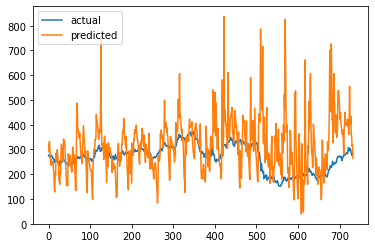

In [89]:
plot_them_graphs(actual_test, predictions_test, "test", ticker)